img zooms = (1.0, 1.0, 2.0)
img orientation code: ('P', 'I', 'R')
Centroid List: [('P', 'I', 'R'), [20, 95.1, 32.8, 26.4], [21, 84.8, 59.0, 26.1], [22, 75.1, 88.4, 26.7], [23, 68.6, 119.8, 27.9], [24, 74.6, 150.2, 28.0]]
[*] Image resampled to voxel size: (1, 1, 1)
[*] Image resampled to voxel size: (1, 1, 1)
[*] Rescaled centroid coordinates to spacing (x, y, z) = (1, 1, 1) mm


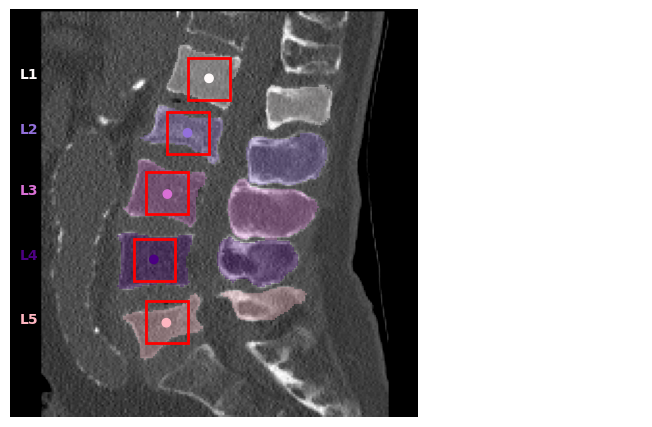

In [18]:
import os
import numpy as np
import nibabel as nib
import nibabel.orientations as nio
import matplotlib.pyplot as plt
from data_utilities import *
from skimage import measure

# Define directory
directory = 'D:\\racunalni_vid\dataset-verse19test\dataset-verse19test\derivatives\sub-verse054'

# Step 4: Load files for a single data sample
img_nib = nib.load(os.path.join(directory, 'sub-verse054_ct.nii.gz'))
msk_nib = nib.load(os.path.join(directory, 'sub-verse054_seg-vert_msk.nii.gz'))
ctd_list = load_centroids(os.path.join(directory, 'sub-verse054_seg-subreg_ctd.json'))

# Check img zooms 
zooms = img_nib.header.get_zooms()
print('img zooms = {}'.format(zooms))

# Check img orientation
axs_code = nio.ornt2axcodes(nio.io_orientation(img_nib.affine))
print('img orientation code: {}'.format(axs_code))

# Check centroids
print('Centroid List: {}'.format(ctd_list))

# Resample and Reorient data
img_iso = resample_nib(img_nib, voxel_spacing=(1, 1, 1), order=3)
msk_iso = resample_nib(msk_nib, voxel_spacing=(1, 1, 1), order=0)
ctd_iso = rescale_centroids(ctd_list, img_nib, (1,1,1))

img_iso = reorient_to(img_iso, axcodes_to=('I', 'P', 'L'))
msk_iso = reorient_to(msk_iso, axcodes_to=('I', 'P', 'L'))
ctd_iso = reorient_centroids_to(ctd_iso, img_iso)

# Check img zooms 

# Get voxel data
im_np  = img_iso.get_fdata()
msk_np = msk_iso.get_fdata()

# Get the mid-slice of the scan and mask in sagittal plane
im_np_sag = im_np[:,:,int(im_np.shape[2]/2)]
im_np_cor = im_np[:,int(im_np.shape[1]/2),:]
msk_np_sag = msk_np[:,:,int(msk_np.shape[2]/2)]
msk_np_sag[msk_np_sag==0] = np.nan
msk_np_cor = msk_np[:,int(msk_np.shape[1]/2),:]
msk_np_cor[msk_np_cor==0] = np.nan

# Plot
fig, axs = create_figure(96,im_np_sag, im_np_cor)
axs[0].imshow(im_np_sag, cmap=plt.cm.gray, norm=wdw_sbone)
axs[0].imshow(msk_np_sag, cmap=cm_itk, alpha=0.3, vmin=1, vmax=64)
plot_sag_centroids(axs[0], ctd_iso, zooms)

# Outline the area of the vertebrae
for centroid in ctd_iso:
    if len(centroid) == 4:  # Check if it's a coordinate tuple (label, X, Y, Z)
        label, x, y, z = centroid
        # Round the coordinates to integers (assuming they are in voxel space)
        x, y, z = int(round(x)), int(round(y)), int(round(z))
        # Extract region of interest around the centroid
        roi = msk_np[max(0, x-10):min(msk_np.shape[0], x+10),
                     max(0, y-10):min(msk_np.shape[1], y+10),
                     max(0, z-10):min(msk_np.shape[2], z+10)]
        # Check if there's any nonzero value in the region
        if np.any(roi):
            # Determine bounding box coordinates
            min_x, max_x = max(0, x-10), min(msk_np.shape[0], x+10)
            min_y, max_y = max(0, y-10), min(msk_np.shape[1], y+10)
            min_z, max_z = max(0, z-10), min(msk_np.shape[2], z+10)
            # Draw rectangle around the bounding box
            axs[0].add_patch(plt.Rectangle((min_y, min_x),
                                           max_y - min_y, max_x - min_x,
                                           fill=False, edgecolor='red', linewidth=2))

# Display the result
plt.show()


In [19]:
import os
import numpy as np
import nibabel as nib
import nibabel.orientations as nio
import matplotlib.pyplot as plt

# custom
from data_utilities import *

directory = 'D:\\racunalni_vid\dataset-verse19test\dataset-verse19test\derivatives\sub-verse054'

# Step 4: Load files for a single data sample
img_nib = nib.load(os.path.join(directory, 'sub-verse054_ct.nii.gz'))
msk_nib = nib.load(os.path.join(directory, 'sub-verse054_seg-vert_msk.nii.gz'))
ctd_list = load_centroids(os.path.join(directory, 'sub-verse054_seg-subreg_ctd.json'))


In [20]:
#check img zooms 
zooms = img_nib.header.get_zooms()
print('img zooms = {}'.format(zooms))

#check img orientation
axs_code = nio.ornt2axcodes(nio.io_orientation(img_nib.affine))
print('img orientation code: {}'.format(axs_code))

#check centroids
print('Centroid List: {}'.format(ctd_list))

img zooms = (1.0, 1.0, 2.0)
img orientation code: ('P', 'I', 'R')
Centroid List: [('P', 'I', 'R'), [20, 95.1, 32.8, 26.4], [21, 84.8, 59.0, 26.1], [22, 75.1, 88.4, 26.7], [23, 68.6, 119.8, 27.9], [24, 74.6, 150.2, 28.0]]


In [21]:
# Resample and Reorient data
img_iso = resample_nib(img_nib, voxel_spacing=(1, 1, 1), order=3)
msk_iso = resample_nib(msk_nib, voxel_spacing=(1, 1, 1), order=0) # or resample based on img: resample_mask_to(msk_nib, img_iso)
ctd_iso = rescale_centroids(ctd_list, img_nib, (1,1,1))

img_iso = reorient_to(img_iso, axcodes_to=('I', 'P', 'L'))
msk_iso = reorient_to(msk_iso, axcodes_to=('I', 'P', 'L'))
ctd_iso = reorient_centroids_to(ctd_iso, img_iso)

#check img zooms 
zooms = img_iso.header.get_zooms()
print('img zooms = {}'.format(zooms))

#check img orientation
axs_code = nio.ornt2axcodes(nio.io_orientation(img_iso.affine))
print('img orientation code: {}'.format(axs_code))

#check centroids
print('new centroids: {}'.format(ctd_iso))

[*] Image resampled to voxel size: (1, 1, 1)
[*] Image resampled to voxel size: (1, 1, 1)
[*] Rescaled centroid coordinates to spacing (x, y, z) = (1, 1, 1) mm
img zooms = (1.0, 1.0, 1.0)
img orientation code: ('I', 'P', 'L')
new centroids: [('I', 'P', 'L'), [20, 32.8, 95.1, 55.2], [21, 59.0, 84.8, 55.8], [22, 88.4, 75.1, 54.6], [23, 119.8, 68.6, 52.2], [24, 150.2, 74.6, 52.0]]


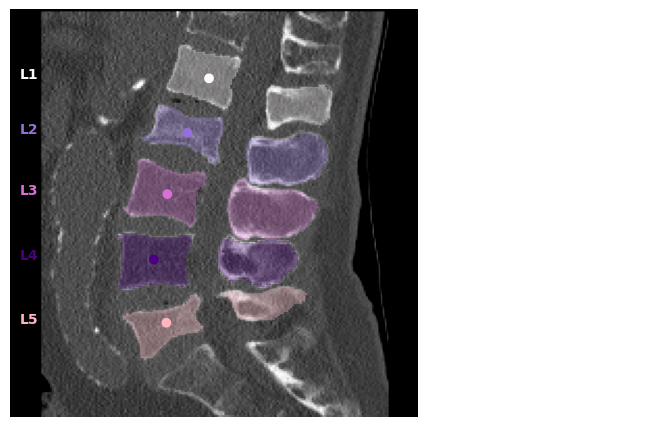

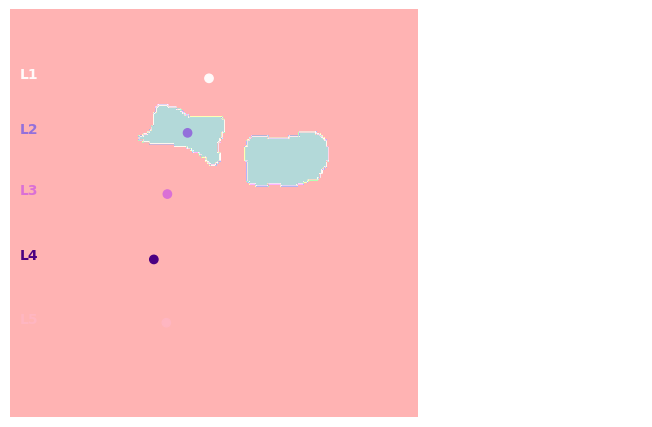

In [50]:
# get vocel data
im_np  = img_iso.get_fdata()
msk_np = msk_iso.get_fdata()


# get the mid-slice of the scan and mask in sagittal plane

im_np_sag = im_np[:,:,int(im_np.shape[2]/2)]
im_np_cor = im_np[:,int(im_np.shape[1]/2),:]

msk_np_sag = msk_np[:,:,int(msk_np.shape[2]/2)]
msk_np_sag[msk_np_sag==0] = np.nan

msk_np_cor = msk_np[:,int(msk_np.shape[1]/2),:]
msk_np_cor[msk_np_cor==0] = np.nan


# plot 
fig, axs = create_figure(96,im_np_sag, im_np_cor)

axs[0].imshow(im_np_sag, cmap=plt.cm.gray, norm=wdw_sbone)
axs[0].imshow(msk_np_sag, cmap=cm_itk, alpha=0.3, vmin=1, vmax=64)
plot_sag_centroids(axs[0], ctd_iso, zooms)

# Select one vertebra to visualize
selected_vertebra_label = 21  

# Create a mask where only the selected vertebra is visible
msk_np_sag_single_vertebra = np.where(msk_np_sag == selected_vertebra_label, 1, 0)

# Plot
fig, axs = create_figure(96, im_np_sag, im_np_cor)
#axs[0].imshow(im_np_sag, cmap=plt.cm.gray, norm=wdw_sbone)
axs[0].imshow(msk_np_sag_single_vertebra, cmap=cm_itk, alpha=0.3, vmin=0, vmax=1)
plot_sag_centroids(axs[0], ctd_iso, zooms)



Prepoznavanje kraljezaka, ali trenutno osim trupa kraljeska prepoznaje i poprecni i trnasti nastavak.x

C:\Users\Moj STROJ\AppData\Local\Temp\ipykernel_17496\743449445.py:4: RuntimeWarning: invalid value encountered in cast
  regions = measure.regionprops(msk_np_sag.astype(int))


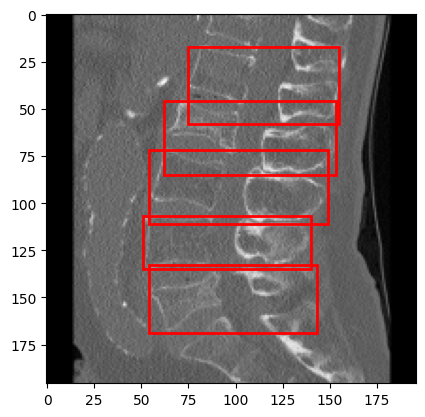

In [23]:
from skimage import measure

# Pronalaženje svake kralježnice kao povezane komponente
regions = measure.regionprops(msk_np_sag.astype(int))

# Crtanje granica svake povezane komponente na originalnoj slici
for region in regions:
    minr, minc, maxr, maxc = region.bbox
    rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                         fill=False, edgecolor='red', linewidth=2)
    plt.gca().add_patch(rect)

# Prikaz rezultata
plt.imshow(im_np_sag, cmap=plt.cm.gray)
plt.show()
